### Us vs. Them Dimension ###

Inspired by the works of Austin C. Kozlowski, Matt Taddy and James A. Evans ([2019](https://arxiv.org/pdf/1803.09288.pdf)) we intend to measure representation of individuals and entities on an in-group out-group space. To do se we focus on three online communities: the /pol/ forum on 4chan.org, the_donald subreddit and breibart comment section. 

From a high dimensionnal space defined by word embeddings we create an "us-them" dimensions from a list of hand-picked antagonist and protagonist terms. Each embeddings are trained months between  2016-05 and 2017-03. We then project political actors, media outlets, communities along this dimension.

We are interested in the change of these entities between the media and through time.

We first load the word embeddings for all of the media and the 12 months (May 2016 to May 2017). Then we load the antagonist and protagonist terms.

In [13]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt

sns.set_style("white")

In [2]:
def load_models(platforms, months):
    models = {}
    for platform in platforms:
        platform_dict = {}
        directory = "../data/models/{}/w2v_models/".format(platform)
        for filename in os.listdir(directory):
            if filename.endswith(".bin") and not filename == "2017-04.bin":
                filepath = os.path.join(directory, filename)
                month = os.path.splitext(filename)[0]
                model = KeyedVectors.load_word2vec_format(filepath,binary=platform=='4chan_pol')
                platform_dict[month] = model
        models[platform] = platform_dict
    return models

# load models
platforms = ["4chan_pol","breitbart","the_donald"]

months= ["2016-05","2016-06","2016-07","2016-08","2016-09","2016-10",
         "2016-11","2016-12","2017-01","2017-02","2017-03"]
mods = load_models(platforms, months)

# load entities
# entities = ['trump','bernie','hillary']


# load seed terms
antagonist = open('../data/seeds/antagonist.txt').read().splitlines()
protagonist = open('../data/seeds/protagonist.txt').read().splitlines()

We then calculate a vector to represent the prototypical antagonist vector and the prototypical protagonist vector. The Us vs. Them dimension is the difference between the vectors.

In [3]:
def dimension_create(positive,negative , name, model):
    """ takes two list of words expected to be negative and positive on the newly created dimension. 
    name the dimension.
    return the updated model

    error with add vector which lead to "out of bound" see:
https://stackoverflow.com/questions/56639993/how-to-add-new-word-vectors-to-gensim-models-keyedvectors-and-calculate-most-sim
    """
    for platform in model:
        for month in model[platform]:
            word_matrix = model[platform][month]
            antagonist_vector = np.mean([word_matrix[meme] for meme in negative if meme in word_matrix], axis=0)
            protagonist_vector = np.mean([word_matrix[meme] for meme in positive if meme in word_matrix], axis=0)

            new_dimension = antagonist_vector - protagonist_vector
            word_matrix.add(name, new_dimension )
            model[platform][month] = word_matrix
            try:
                del model[platform][month].vectors_norm #
            except:
                pass
    return model

In [4]:
def rank_over_time(platforms, entities, model, dimension):
    similarity_list = {"platform": [], "entity":[], "month":[], "rank":[]}
    for platform in model:
        for month in model[platform]:
            ranking = pd.DataFrame(model[platform][month].most_similar(dimension, topn=2000000))
            ranking = ranking.reset_index()
            for entity in entities:
                rank = abs(1 - ranking.loc[ranking[0] == entity].index[0] / len(ranking.index))
                similarity_list["platform"].append(platform)
                similarity_list["entity"].append(entity)
                similarity_list["month"].append(month)
                similarity_list["rank"].append(rank)
    return similarity_list

In [6]:
models = mods
models = dimension_create(negative =  antagonist,
                     positive = protagonist,
                     name = 'usthem_dimension', 
                     model = models)

models = dimension_create(negative = ["democrat","dnc","liberal","leftist","libtard"],
                        positive = ["republican","gop","conservative","repub"],
                        name = 'con_lib', 
                        model = models)

models = dimension_create(positive = ["democrat","dnc","liberal","leftist","libtard"],
                        negative = ["republican","gop","conservative","repub"],
                        name = 'lib_con', 
                        model = models)

models["4chan_pol"]["2016-06"].most_similar("con_lib")
models["4chan_pol"]["2016-06"].most_similar("lib_con")

[('sandnigger', 0.4076864719390869),
 ('mudslime', 0.4054054319858551),
 ('favela', 0.40228360891342163),
 ('gypsy', 0.3980713486671448),
 ('sandniggers', 0.3921383321285248),
 ('turkroach', 0.3920011520385742),
 ('subhuman', 0.38791728019714355),
 ('riddled', 0.36912447214126587),
 ('sub-human', 0.36047470569610596),
 ('monkey', 0.36009013652801514)]

In [7]:
#save to csv
# df.to_csv("../data/politican_against_them.csv", sep='\t', encoding='utf-8')

Text(0, 0.5, 'distance')

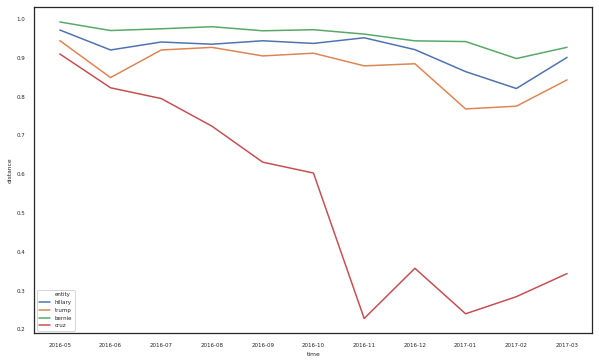

In [29]:
entities = ['hillary','trump', 'bernie','cruz']
platform = ['4chan_pol', 'the_donald', 'breitbart']

df = pd.DataFrame(rank_over_time(platforms, entities,models, "usthem_dimension"))

plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="month", y="rank", hue="entity", data=df.loc[df['platform'] == platform[0]])
plt.xlabel('time')
plt.ylabel('distance')

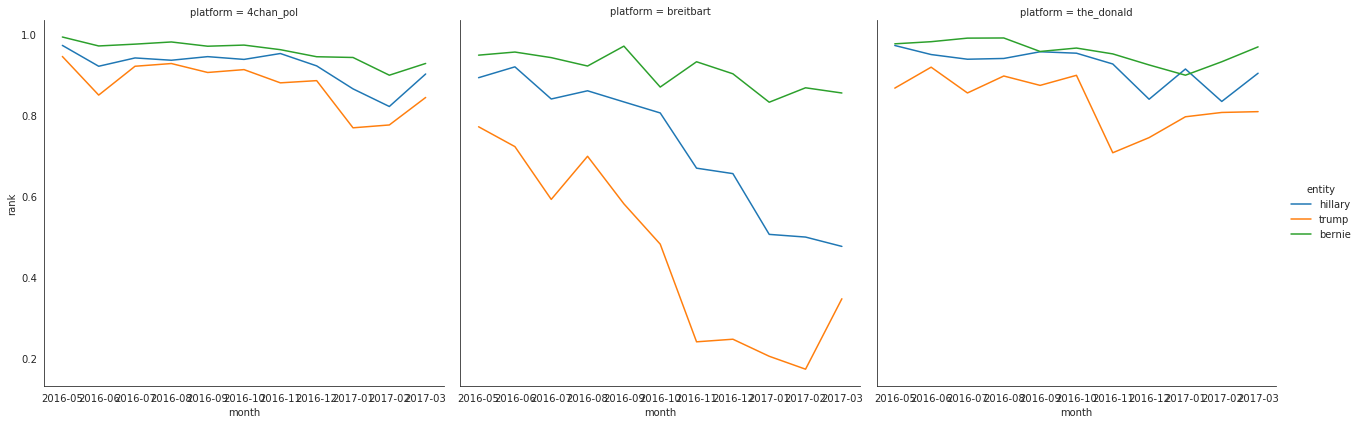

In [21]:
g = sns.FacetGrid(df, col="platform",height=6, hue="entity")
g.map(sns.lineplot, "month", "rank").add_legend()

In order to observe how those politican relate to each other on two dimension at the time the "us vs. (((them)))" against a dimension which we would call "conservative vs. liberals" let's compute score for each of them with the below function "bi_dimensional_rank".

In [24]:
# plotting entities on two created dimension
def bi_dimensional_rank(entities, dimensions, model):
    """ dimensions is a named list of 2 strings"""
    measured_similarity = {"platform": [], "entity":[], "month":[],
                           dimensions[0] :[],dimensions[1]:[]}
    for platform in model:
        for month in model[platform]:
            for entity in entities:
                ranking1 = pd.DataFrame(model[platform][month].most_similar(dimensions[0], topn=2000000))
                ranking1 = ranking1.reset_index()
                rank1 = abs(1 - ranking1.loc[ranking1[0] == entity].index[0] /
                           len(ranking1.index))
                ranking2 = pd.DataFrame(model[platform][month].most_similar(dimensions[1], topn=2000000))
                ranking2 = ranking2.reset_index()
                rank2 = abs(1 - ranking2.loc[ranking2[0] == entity].index[0] /
                           len(ranking2.index))
                
                measured_similarity["platform"].append(platform)
                measured_similarity["entity"].append(entity)
                measured_similarity["month"].append(month)
                measured_similarity[dimensions[0]].append(rank1)
                measured_similarity[dimensions[1]].append(rank2)

    return measured_similarity

In [37]:
list_rank = bi_dimensional_rank(entities, ["con_lib","usthem_dimension"], models)
df2 = pd.DataFrame(list_rank)

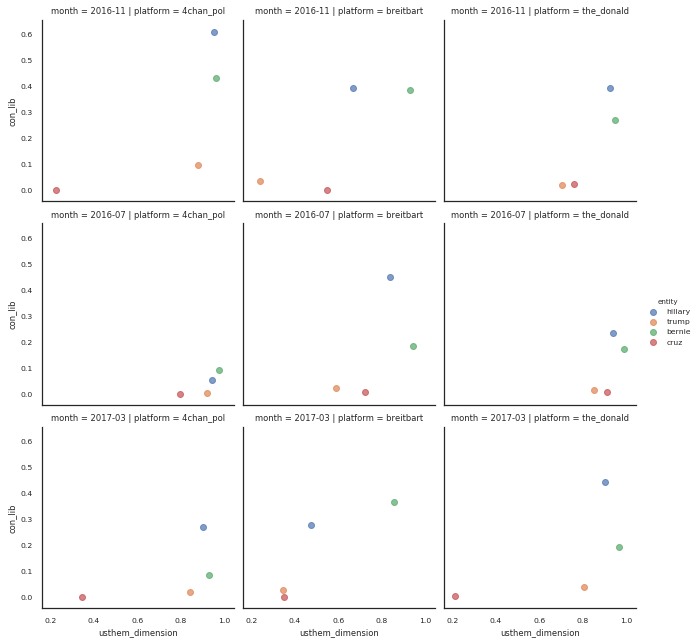

In [38]:
df_sub = df2[df2["month"].isin(["2016-07","2016-11","2017-03"])] #subset for easier plotting
#df_sub = df_sub.sort_values(by=['month']) # if sorted trump is not orange anymore ...
sns.set(font_scale=.7, style = "white" )
g = sns.FacetGrid(df_sub, row="month",col = "platform", hue="entity", height = 3)
g = (g.map(plt.scatter, "usthem_dimension","con_lib",alpha=.7).add_legend())